# Capstone Project

## Import Libraries and set environment

In [1]:
import os

import pandas as pd
#import seaborn as sns #must be installed in SM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Set environment variables 
session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "capstone520"
prefix = "data/"

## Explore data

In [4]:
# Import data
dataset = pd.read_csv("data/ecoli_structure_filtered.csv")
dataset.head()

,...1,bacterium,modifications,sequence,strain,unit,url_source,log(MIC),pMIC,is_modified,...,sequence_len,id,secondary_structure,len,helix_group,sheet_group,coil_group,helix_percentage,sheet_percentage,coil_percentage
0,2112,E. coli,[],AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=5613,2.10,3.90,False,...,33,GRAMPA_1984,CCCHHHHHHHCCCHHHHHHHHHHHHHHHHHCCC,33,70-80,0-10,20-30,72.73,0.00,27.27
1,5527,E. coli,[C-Terminus: AMD],AAAAAAAIKMLMDLVNERIMALNKKAKK,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=7719,1.00,5.00,True,...,28,GRAMPA_5154,CCCHHHHHHHHHHHHHHHHHHHHHHCCC,28,70-80,0-10,20-30,78.57,0.00,21.43
2,7671,E. coli,[],AAAAGSVWGAVNYTSDCNGECKRRGYKGGYCGSFANVNCWCET,NaN,uM,http://www.yadamp.unisa.it/showItem.aspx?yadam...,2.00,4.00,False,...,43,GRAMPA_5919,CCCCCCCECCCCECCCHHHHHHHCCCCEEEEECCCCCEEEEEC,43,10-20,20-30,50-60,16.28,27.91,55.81
3,3562,E. coli,[],AAAKAALNAVLVGANA,TG1,uM,https://dbaasp.org/peptide-card?id=618,1.90,4.10,False,...,16,GRAMPA_3326,CCCHHHHHHHHHCCCC,16,50-60,0-10,40-50,56.25,0.00,43.75
4,5678,E. coli,[],AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,NaN,uM,https://dbaasp.org/peptide-card?id=5171,0.25,5.75,False,...,40,GRAMPA_5298,CCCCCCCCCCCECCCCCCCCCCCCCCEEEECECHHCCCCC,40,0-10,10-20,70-80,5.00,15.00,80.00


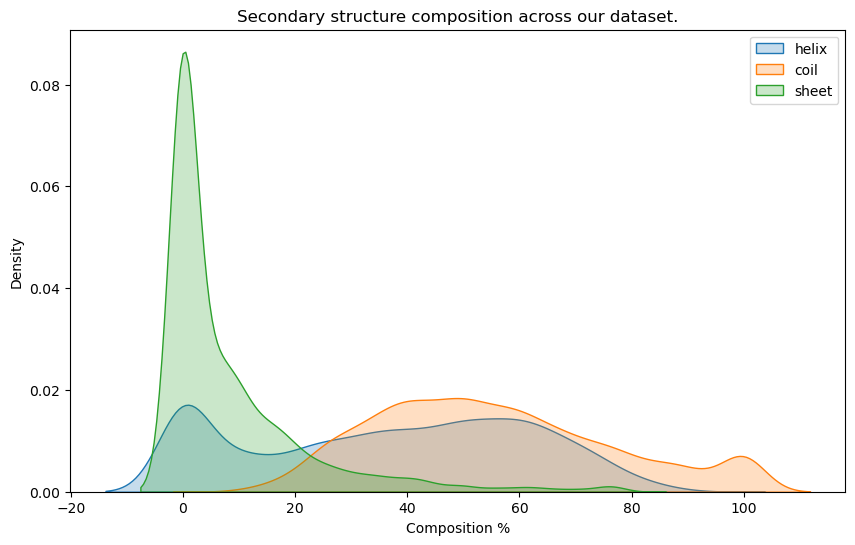

In [3]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Density plots for secondary structure composition 
sns.kdeplot(dataset["helix_percentage"], label="helix", fill=True) #kde: Kernel Density Estimate
sns.kdeplot(dataset["coil_percentage"], label="coil", fill=True)
sns.kdeplot(dataset["sheet_percentage"], label="sheet", fill=True)

# Customize the plot
plt.title("Secondary structure composition across our dataset.")
plt.xlabel("Composition %")
plt.legend()

# Show plot
plt.show()

In [5]:
dataset.columns

Index(['...1', 'bacterium', 'modifications', 'sequence', 'strain', 'unit',
       'url_source', 'log(MIC)', 'pMIC', 'is_modified',
       'has_unusual_modification', 'has_cterminal_amidation',
       'datasource_has_modifications', 'database', 'sequence_len', 'id',
       'secondary_structure', 'len', 'helix_group', 'sheet_group',
       'coil_group', 'helix_percentage', 'sheet_percentage',
       'coil_percentage'],
      dtype='object')

C:\Users\Momas\AppData\Local\Temp\ipykernel_17872\1674920667.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


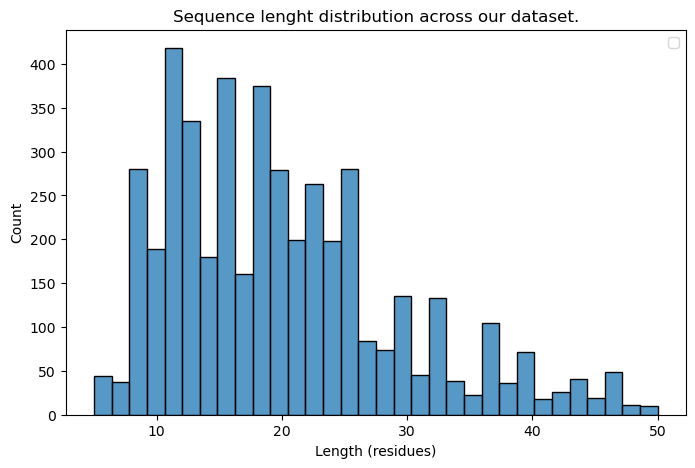

In [8]:
# Create figure and axis
plt.figure(figsize=(8, 5))

# Density plots for secondary structure composition 
sns.histplot(dataset["sequence_len"], kde=False)

# Customize the plot
plt.title("Sequence lenght distribution across our dataset.")
plt.xlabel("Length (residues)")
plt.legend()

# Show plot
plt.show()

In [5]:
dataset.shape

(4540, 24)

## Prepare data

### Split the data

We will create data splits required to train, tune and test our models. We'll use 75% of our original data i.e. 3,405 sequences to train the models, and split in half the remaining 25% to create both our testing and validation datasets.  

In [6]:
train_split, temp_split = train_test_split(dataset, test_size=0.25, random_state=42)

In [7]:
test_split, val_split = train_test_split(temp_split, test_size=0.5, random_state=42)

In [8]:
# Remove the target from the test dataset
test_split = test_split.drop(columns=["pMIC"])

In [9]:
print(f"Training set size: {len(train_split)}")
print(f"Validation set size: {len(val_split)}")
print(f"Test set size: {len(test_split)}")

Training set size: 3405
Validation set size: 568
Test set size: 567


### Save datasets for each split
We'll save each data split in a separate named directory so we can have more control to how we pass data to the traininng/HPO jobs.

In [10]:
# Save each split as CSV files
train_split.to_csv("data/train/ecoli_train_im.csv", index=False)
val_split.to_csv("data/validation/ecoli_val_im.csv", index=False)
test_split.to_csv("data/test/ecoli_test_im.csv", index=False)

In [11]:
torch.__version__

'2.3.1.post100'

### Upload data to S3

In [12]:
# Upload data 
training_inputs = session.upload_data(path="data/train/ecoli_train_im.csv", bucket=bucket, key_prefix=prefix + "train")
validation_inputs = session.upload_data(path="data/validation/ecoli_val_im.csv", bucket=bucket, key_prefix=prefix + "validation")
test_inputs = session.upload_data(path="data/test/ecoli_test_im.csv", bucket=bucket, key_prefix=prefix + "test")

Define the inputs to the HPO job

In [13]:
# Set the input channels usig the URIs from the uplpoad
inputs = {'training': training_inputs,
          'validation': validation_inputs,
          'test': test_inputs}

In [3]:
# For re-running the notebook only
inputs = {'training': 's3://capstone520/data/train/ecoli_train_im.csv',
          'validation': 's3://capstone520/data/validation/ecoli_val_im.csv',
          'test': 's3://capstone520/data/test/ecoli_test_im.csv'}

In [4]:
inputs

{'training': 's3://capstone520/data/train/ecoli_train_im.csv',
 'validation': 's3://capstone520/data/validation/ecoli_val_im.csv',
 'test': 's3://capstone520/data/test/ecoli_test_im.csv'}

## Perform Hyperparameter Optimization

### Instance the Estimator
We can use utility custom code when launching a training job. For that we must compress our code and upload it to S3. 
<details>
    <summary> Click here to see the steps </summary>

```bash
#Using the Amazon SM jupyter server terminal
pwd
>>> /home/sagemaker-user
ls
>>> aws_udacity_capstone_project
tar -czf project.tar.gz -C aws_udacity_capstone_project/ .
>>>
aws s3 cp project.tar.gz s3://capstone520/

```

</details>

In [24]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_im.py",
    source_dir="s3://capstone520/project.tar.gz", #to use custom modular code
    role=role,
    py_version="py310",
    framework_version="2.2",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters={
        "epochs": 30 #we'll use a fixed number of epochs
    }
)

### Configure hyperparameter tuner

The metric_definitions parameter is crucial when using SageMaker’s Hyperparameter Tuner, as it tells the tuner how to interpret and extract metrics from the training output logs. The regular expression is used to search the output logs for the metric.

In [29]:
hyperparameter_ranges = {
    #"epochs": IntegerParameter(5, 10), # (min, max)
    "learning_rate": CategoricalParameter([0.0003, 0.001, 0.005, 0.01]),
    "batch_size": CategoricalParameter([128, 254])
}

metric_definitions = [{"Name": "Validation MSE",
                      "Regex": "Validation MSE: *([0-9\\.]+)"}]

#Instance hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="Validation MSE",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type="Minimize",
    max_jobs=8, #adjust this to run the combination of desired runs wo. using parallel training
    max_parallel_jobs=1,
    base_tuning_job_name="hpo-ecoli-im01"
)

In [30]:
tuner.fit(inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................!


### Compare with benchmark

[insert image of benchmark ]

In [31]:
# Get the hyperparams from the best run
best_estimator = tuner.best_estimator()

best_hyperparams = best_estimator.hyperparameters()
best_hyperparams


2024-10-18 19:08:37 Starting - Preparing the instances for training
2024-10-18 19:08:37 Downloading - Downloading the training image
2024-10-18 19:08:37 Training - Training image download completed. Training in progress.
2024-10-18 19:08:37 Uploading - Uploading generated training model
2024-10-18 19:08:37 Completed - Resource reused by training job: hpo-ecoli-im01-241018-1902-002-f8bad135


{'_tuning_objective_metric': '"Validation MSE"',
 'batch_size': '"128"',
 'epochs': '30',
 'learning_rate': '"0.01"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-10-18-19-02-09-448"',
 'sagemaker_program': '"hpo_im.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://capstone520/project.tar.gz"'}

In [32]:
# Retrieve each hyperparam
batch_size = str(best_hyperparams.get("batch_size", ""))
epochs = str(best_hyperparams.get("epochs", ""))
learning_rate = str(best_hyperparams.get("learning_rate", ""))

print(f"Batch size: {batch_size}, Epochs: {epochs}, Learning rate: {learning_rate}")

Batch size: "128", Epochs: 30, Learning rate: "0.01"


## Model Profiling and debugging

### Set hyperparmeters for our training job
We'll train our model with the best hyperparameters from the last HPO training jobs.

In [ ]:
# Set hyperparams for the training job, this can also be done in a script
hyperparameters = {
    "batch_size": 128,
    "epochs": 30,
    "learning_rate": 0.01
}

#### Key concepts of Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and provides you alerts, once it has detected inconsistency in training flow.

Concepts
- Tensors: These represent the state of the training network at intermediate points during its execution
- Debug Hook: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
- Rule: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all



#### Create rules and hooks 

In [ ]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

# Create profiling and debugging rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [ ]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Set profiler and debugger configs
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=10) 
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"} 
)

### Launch a Trainig Job in SageMaker

#### Create the PT estimator

In [ ]:
from sagemaker.pytorch import PyTorch
#role = sagemaker.get_execution_role()

estimator = PyTorch(
    base_job_name="train-eco-im01", #Change for every training job
    role=role,
    entry_point="train_eco_im.py",
    dependencies=["./scripts/requirements.txt"],
    source_dir="s3://capstone520/project.tar.gz", #to use custom modular code
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    framework_version=2.2,
    py_version="py310",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

#### Train the estimator

In [ ]:
# Train our model
estimator.fit(inputs, wait=True)

Prepare for debugging and profiling analysis [required? Maybe just display the report]

## Deploy the trained model

## Perform inference on the testing data